In [1]:
from pynq import Overlay
from pynq import allocate
from pynq import MMIO
import numpy as np
from time import time
from tqdm import tqdm
import cffi

ffi = cffi.FFI()

In [2]:
# Prepare the custome overlay and DMA
ol = Overlay("/home/xilinx/classifier.bit")
ol.download()

dma_mm2s = ol.axi_dma_0
dma_s2mm = ol.axi_dma_1

# Accelerator Base Address
ACCEL_CTRL = 0x43C00000

# Initialize HLS IP
mmult_ip = MMIO(ACCEL_CTRL, 0x10000)

# Start the accelerator
ctrl = mmult_ip.read(0x00) & 0x08
mmult_ip.write(0x00, (ctrl | 0x81))
ctrl = mmult_ip.read(0x00)
hex(ctrl)

'0x81'

In [3]:
# Classifier Dimensions
BATCH = 8192
FEAT = 64
HIDDEN = 16
CLASSES = 10

# AXI_WIDTH = 256
AXI_WIDTH = 64
AXI_WIDTH_BYTES = AXI_WIDTH // 8


def inv(val, mod):
    return (mod - (val % mod)) % mod
    

def serialize(offset, weight1, weight2, inputs):
    # Pack Offset
    assert offset.dtype == np.int16
    assert offset.shape == (CLASSES,)
    bo = offset.flatten().tobytes() + b"\x00" * inv( 2*CLASSES , AXI_WIDTH_BYTES )
    assert len(bo) % AXI_WIDTH_BYTES == 0

    # Pack Weight1 (int8)
    assert weight1.dtype == np.int8
    assert weight1.shape == (HIDDEN, FEAT)
    assert len(weight1[0].tobytes()) % AXI_WIDTH_BYTES == 0
    bw1 = weight1.flatten().tobytes()

    # Pack Weight2 (int8)
    assert weight2.dtype == np.int8
    assert weight2.shape == (CLASSES, HIDDEN)
    assert len(weight2[0].tobytes()) % AXI_WIDTH_BYTES == 0
    bw2 = weight2.flatten().tobytes()

    # Pack Input (uint4)
    assert inputs.dtype == np.uint8
    assert inputs.shape == (BATCH, FEAT)
    assert len(weight1[0].tobytes()) % AXI_WIDTH_BYTES == 0
    bi_wide = inputs.flatten().tobytes()
    bi = bytearray(
        (bi_wide[i] << 4) | bi_wide[i + 1] for i in range(0, len(bi_wide), 2)
    )
    assert len(bi) == BATCH * FEAT // 2
    assert len(bi) % AXI_WIDTH_BYTES == 0

    return bo + bw1 + bw2 + bi


OUT_WIDTH = CLASSES + inv(CLASSES, AXI_WIDTH_BYTES // 2)
def deserialize(output: np.array):
    assert output.dtype == np.int16
    output = output.reshape(BATCH, OUT_WIDTH)[:, :CLASSES]
    assert output.shape == (BATCH, CLASSES)
    return np.argmax(output, axis=1)

In [4]:
# Initialize offsets, weights and inputs
test_input = np.load("test_data_custom.npy")[0:BATCH]
o = np.load("model_bias_custom.npy")
w1 = np.load("model_weight1_custom.npy")
w2 = np.load("model_weight2_custom.npy")
test_label = np.load("test_label_custom.npy")[0:BATCH]

In [5]:
# Move offset, weight and input data to DMA buffer
ibuf = serialize(o, w1.transpose(), w2.transpose(), test_input)

mm2s_buffer = allocate(shape=(len(ibuf),), dtype=np.uint8)
s2mm_buffer = allocate(shape=(BATCH * OUT_WIDTH,), dtype=np.int16)

ffi.memmove(mm2s_buffer[:], ibuf, len(ibuf))
mm2s_buffer.flush()

In [6]:
# Perform FPGA offloading
def fpga_test():
    start_t = time()
    dma_mm2s.sendchannel.transfer(mm2s_buffer)
    dma_s2mm.recvchannel.transfer(s2mm_buffer)
    dma_mm2s.sendchannel.wait()
    dma_s2mm.recvchannel.wait()
    fpga_time = time() - start_t

    # Dump FPGA result to a numpy array
    pred = deserialize(np.array(s2mm_buffer))
    return pred, fpga_time

In [7]:
# Test on CPU
def cpu_test():
    def predict(inputs, w1, w2, b):
        hid = inputs @ w1
        hid = hid * (hid > 0)
        out = hid @ w2 + b
        return out

    start_t = time()
    out = predict(test_input, w1, w2, o)
    cpu_time = time() - start_t

    pred = np.argmax(out, axis=1)
    return pred, cpu_time

In [8]:
perf_f = []
perf_c = []

for _ in tqdm(range(32)):
    pred_f, time_f = fpga_test()
    pred_c, time_c = cpu_test()
    perf_f.append(time_f)
    perf_c.append(time_c)


perf_f = np.array(perf_f) * 1000
perf_c = np.array(perf_c) * 1000
time_f = perf_f.mean()
time_c = perf_c.mean()
time_f, time_c

100%|██████████| 32/32 [00:05<00:00,  5.37it/s]


(4.540383815765381, 169.64392364025116)

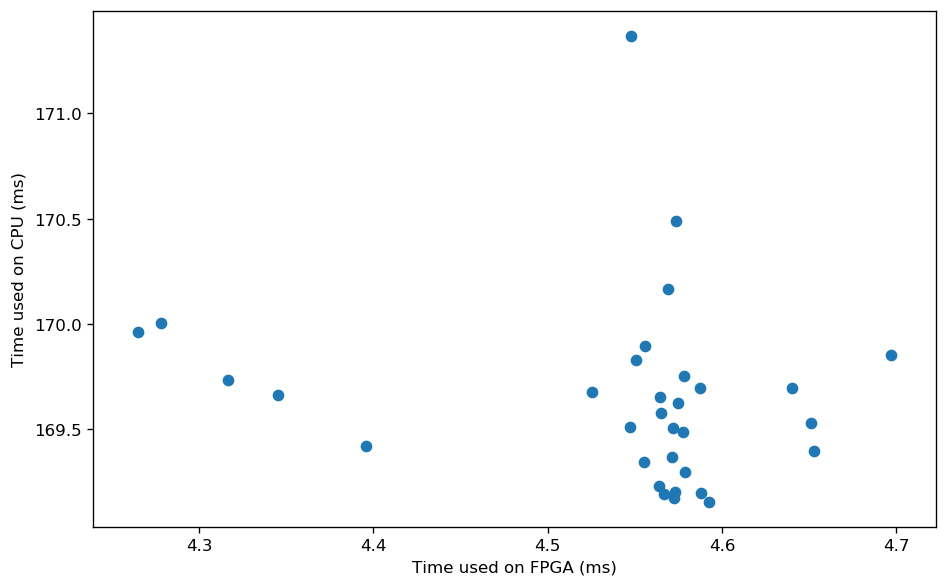

In [9]:
def stat():
    from matplotlib import pyplot as plt

    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
    ax.scatter(perf_f, perf_c)
    ax.set_xlabel("Time used on FPGA (ms)")
    ax.set_ylabel("Time used on CPU (ms)")

    return fig


fig = stat()
fig.tight_layout()

In [10]:
# Evaluate validation accuracy
errors_c = np.sum(pred_c == test_label)
errors_f = np.sum(pred_f == test_label)

# Report results
print("FPGA accuracy: {0:.2f}% validation accuracy".format(errors_f / BATCH * 100))
print("CPU  accuracy: {0:.2f}% validation accuracy".format(errors_c / BATCH * 100))
if time_c < time_f:
    print("FPGA has a {0:.2f}x slowdown".format(time_f / time_c))
else:
    print("FPGA has a {0:.2f}x speedup".format(time_c / time_f))

FPGA accuracy: 88.18% validation accuracy
CPU  accuracy: 88.18% validation accuracy
FPGA has a 37.36x speedup
